In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset,DataLoader,random_split,TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import notebook 
import matplotlib.pyplot as plt
import time
import os
import pickle 
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [2]:
device = 'mps:0' if torch.backends.mps.is_available else 'cpu'

In [3]:
os.path.abspath('.')

'/Users/hwanghyeonseog/졸업학위논문 관련 코딩 /Hubbard_model /Old data'

In [4]:
# with open('/Users/hwanghyeonseog/Desktop/Hubbard_old_data/U10D2-40/U10D2-40/U10_Delta2/phi_U10_D2.npy', 'rb') as file:
#     del2= pickle.load(file)
# with open('/Users/hwanghyeonseog/Desktop/Hubbard_old_data/U10D2-40/U10D2-40/phi_U10_D40', 'rb') as file:
#     del40= pickle.load(file)

In [5]:
def MinMaxscaling(data):
    scaling_data = (data - np.min(data))/(np.max(data)-np.min(data))
    return scaling_data

In [6]:
d2  = np.load('/Users/hwanghyeonseog/Desktop/Hubbard_old_data/L20/L20_nmax15_U10_T0_1/phi_lstD1.npy')
d10 = np.load('/Users/hwanghyeonseog/Desktop/Hubbard_old_data/L20/L20_nmax15_U10_T0_1/phi_lstD10.npy')

In [7]:
# scaler = MinMaxScaler()

# scaler.fit(del2)
# scaler.fit(del40)

# scaling_U2  = scaler.transform(del2)
# scaling_U40 = scaler.transform(del40)

scaling_d2  = MinMaxscaling(d2)
scaling_d10 = MinMaxscaling(d10)

In [8]:
reshape_d2  = scaling_d2.reshape(10000,1,20,20)
reshape_d10 = scaling_d10.reshape(10000,1,20,20)

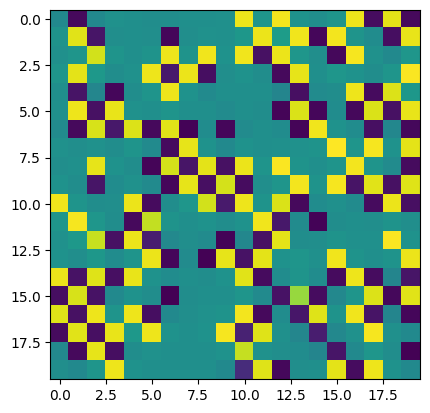

In [9]:
plt.imshow(reshape_d10[0][0])

In [10]:
zeros = np.zeros((10000))
ones  = np.ones((10000))

In [11]:
train_data = np.concatenate((reshape_d2,reshape_d10))
train_label = np.concatenate((zeros,ones))

In [12]:
tensor_train_data = torch.FloatTensor(train_data)
tensor_train_label = torch.FloatTensor(train_label)

In [13]:
batch = 32
lr = 1e-5

In [14]:
trainset    = TensorDataset(tensor_train_data,tensor_train_label)
train_loader = DataLoader(dataset= trainset, batch_size = batch, shuffle = True)

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=128, kernel_size=4, stride=1)
        self.conv2 = nn.Conv2d(in_channels=128,out_channels=256, kernel_size=4, stride=1)

        self.fc1 = nn.Linear(256*14*14, 32)
        self.fc2 = nn.Linear(32, 1)
    
    def forward(self, x):
        

        
        x = F.relu(self.conv1(x))
        
        
        x = F.relu(self.conv2(x))
    

#         print("차원 감소 후", x.size())
        

        x = x.view(-1, 256*14*14)

        x = F.relu(self.fc1(x))
    
        x = self.fc2(x)
        
        x = F.sigmoid(x)
    
    
        return x

In [16]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
criterion = nn.BCELoss()

  0%|          | 0/15 [00:00<?, ?it/s]

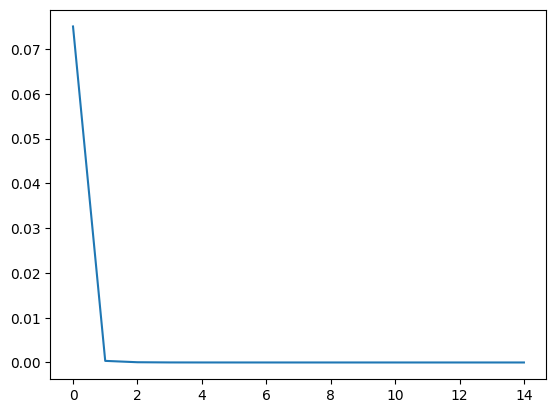

In [17]:
result = []
epochs = 15

s_t = time.time()
for epoch in notebook.tqdm(range(epochs)):
    running_loss = 0.0
    num          = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # labels = labels.type(torch.LongTensor)
        labels = labels.view(len(labels),-1)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        num = num + 1.0
        
    result.append(running_loss / num) 
plt.plot(result)
plt.show()
e_t = time.time()

In [18]:
delta_list  = [x for x in range(2,10)]
result_list = []
model.eval().to('cpu')
for i in delta_list:
    
    data = torch.FloatTensor(MinMaxscaling(np.load(f'/Users/hwanghyeonseog/Desktop/Hubbard_old_data/L20/L20_nmax15_U10_T0_1/phi_lstD{i}.npy')))
#     data = torch.FloatTensor(np.load(f"phi_lstD{i}.npy"))
    data_ = data.view(1000,1,20,20)
    result = model(data_)
    result_list.append(torch.mean(result).detach().numpy())

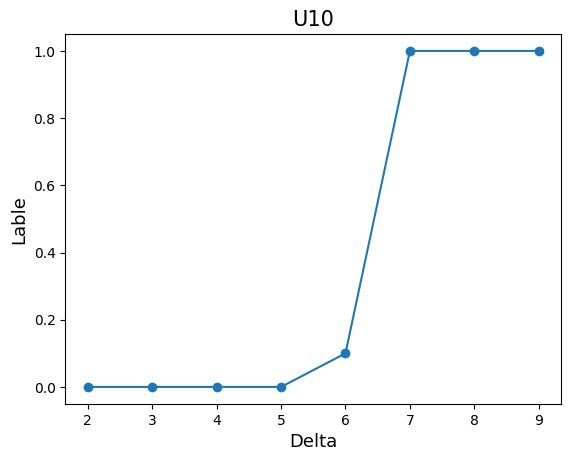

In [27]:
plt.plot(delta_list,np.round(result_list,1),marker='o')
plt.title('U10',fontsize=15)
plt.xlabel('Delta',fontsize=13)
plt.ylabel('Lable',fontsize=13)
plt.show()

In [20]:
result_list

[array(3.1645342e-08, dtype=float32),
 array(4.767606e-08, dtype=float32),
 array(8.550202e-08, dtype=float32),
 array(5.7443464e-07, dtype=float32),
 array(0.13671933, dtype=float32),
 array(0.9963007, dtype=float32),
 array(0.9999444, dtype=float32),
 array(0.9999993, dtype=float32)]

In [22]:
# torch.save(model,'./save/U=10,MinMax')